# Source code : https://github.com/SankhaSubhra/GAMO


In [1]:
from __future__ import print_function, unicode_literals
from __future__ import absolute_import, division
import pandas as pd
import os
import numpy as np
import dense_suppli as spp
import dense_net as nt
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils import array_to_img
import numpy as np

In [2]:
def GAMO_model_load(imbClsNum, trainS, classMap, c):
    latDim =100
    # model initialization
    mlp=nt.denseMlpCreate()
    mlp.compile(loss='mean_squared_error', optimizer=adamOpt)
    mlp.trainable=False

    dis=nt.denseDisCreate()
    dis.compile(loss='mean_squared_error', optimizer=adamOpt)
    dis.trainable=False

    gen=nt.denseGamoGenCreate(latDim)
    gen_processed, genP_mlp, genP_dis=list(), list(), list() # 빈 리스트 생성
    
    #생성자 모델, 생성자 후처리 모델, 판별자 모델
    # genP_mlp : 출력층은 즈강된 데이터를 입력으로 받을 때 MLP 예측값을 출력. 이 MLP 모델을 이 리스트에 추가
    for i in range(imbClsNum):
        dataMinor=trainS[classMap[i], :] #train 데이터셋에서 소수 클래스인 것들이 들어감
        numMinor=dataMinor.shape[0]
        gen_processed.append(nt.denseGenProcessCreate(numMinor, dataMinor))
        # 생성자로부터 생성된 가짜 데이터를 입력으로 받아, 그 데이터를 변환하여 수정하는 역할
        
        #증강된 데이터를 기반으로 MLP 학습
        ip1=Input(shape=(latDim,)) # 랜덤 노이즈
        ip2=Input(shape=(c,)) # 추가 입력 데이터
        op1=gen([ip1, ip2]) #가짜 데이터 생성
        op2=gen_processed[i](op1) # 생성자 후처리 모델에 생성한 가짜 데이터를 처리
        # 가짜 데이터를 gen_processed[i] 모델에 입력하여 처리하는 코드
        '''
        op1: 생성기가 생성한 가짜 데이터, 
        op2: 생성기가 생성한 가짜 데이터를 gen_processed[i] 모델에 입력하여, 
        생성기가 생성한 가짜 데이터에 클래스별 가중치를 적용하여 실제 데이터와 비슷한 분포를 갖도록
        '''
        
        op3=mlp(op2) # mlp 모델을 사용하여 증강된 데이터를 분류한 결과를 op3에 저장
        genP_mlp.append(Model(inputs=[ip1, ip2], outputs=op3))
        genP_mlp[i].compile(loss='mean_squared_error', optimizer=adamOpt)
        # 새로 생성된 모델을 컴파일, 모델의 손실한수로는 평균제곱오차 사용, adam 옵티마이저를 사용해 모델 최적화

        #증강된 데이터를 기반으로 판별기 학습
        ip1=Input(shape=(latDim,))
        ip2=Input(shape=(c,))
        ip3=Input(shape=(c,))
        op1=gen([ip1, ip2])
        op2=gen_processed[i](op1)
        op3=dis([op2, ip3])
        genP_dis.append(Model(inputs=[ip1, ip2, ip3], outputs=op3))
        genP_dis[i].compile(loss='mean_squared_error', optimizer=adamOpt)
    
    return mlp, gen, genP_mlp, gen_processed, dis, genP_dis


In [3]:
def GAMO_training(max_step, mlp, gen, genP_mlp, gen_processed, dis, genP_dis, trainS, testS, labelsCat, latDim, toBalance, imbClsNum):
    batchDiv, numBatches, bSStore=spp.batchDivision(n, batchSize)
    genClassPoints=int(np.ceil(batchSize/c)) # 클래스별 가짜 데이터 양을 설정
    iter=np.int(np.ceil(max_step/resSamplePd)+1) # 학습의 반복 횟수를 계산
    fake_data_list = []  # 가짜 데이터를 저장할 리스트
    step = 0
        
    while step < max_step:
        
        for j in range(numBatches): # 배치를 반복해 학습 진행
            x1, x2 = batchDiv[j, 0], batchDiv[j+1, 0] # 데이터 배치 나누기
            validR = np.ones((bSStore[j, 0], 1)) - np.random.uniform(0, 0.1, size=(bSStore[j, 0], 1))
            '''
            validR : 1에 가까운 값이지만 약간의 노이즈를 포함한 레이블로 사용됨
            학습 데이터를 뒤틀어서 모델이 노이즈에 강건하게 학습하도록 돕는 방법 > 일반화 능력을 향상시키는데 도움
            '''
            
            # 모델 학습 중에 사용
            mlp.train_on_batch(trainS[x1:x2], labelsCat[x1:x2]) # 생성자 학습
            # 학습 데이터와 그에 상응하는 레이블을 한 배치에 대해 학습하는 코드
            # [x1:x2] 슬라이싱을 통해 현재 배치에 해당하는 레이블을 선택
            '''
            선택된 배치의 학습 데이터와 레이블을 사용하여 MLP 모델을 학습시키는 역할. 
            이 과정을 반복하면서 모델은 데이터에 맞게 가중치를 조정하고 손실을 최소화하도록 학습
            '''
            
            dis.train_on_batch([trainS[x1:x2], labelsCat[x1:x2]], validR) # 판별자 학습
            ''' 판별자 학습
            주어진 데이터가 실제 데이터인지 가짜 데이터인지 판별
            validR은 실제 데이터에 해당하는 레이블로, 이 값은 1로 설정. 따라서 판별자 모델은 주어진 데이터가 실제 데이터임을 판별하도록 학습
            '''
            
            invalid=np.zeros((bSStore[j, 0], 1))+np.random.uniform(0, 0.1, size=(bSStore[j, 0], 1))
            ''' 판별자 모델 학습할 때 사용되는 레이블
            레이블은 판별자 모델이 가짜 데이터와 실제 데이터를 구분하도록 학습할 때 사용
            validR : "유효(valid)"한 데이터를 나타내는 레이블 !판별자 모델이 실제 데이터를 식별하도록!
            invalid :  "무효(invalid)"한 데이터를 나타내는 레이블, 진짜 데이터를 식별하도록 하는 것
            '''
            
            randNoise=np.random.normal(0, 1, (bSStore[j, 0], latDim)) # 랜덤 노이즈 생성
            fakeLabel=spp.randomLabelGen(toBalance, bSStore[j, 0], c) #가짜 레이블을 생성하는 코드
            
            # print(fakeLabel) # 위에 relabel 에서 소수클래스 1을 0으로 치환해서 진행했으므로
            #[1,0] 이렇게 생성됨 클래스0이 소수클래스니까
            
            rLPerClass=spp.rearrange(fakeLabel, imbClsNum)#페이크라벨 재배열
            fakePoints=np.zeros((bSStore[j, 0], 250))#가짜 데이터 포인트 저장
            genFinal=gen.predict([randNoise, fakeLabel])
            #생성자 모델을 사용하여 가짜데이터를 생성한 결과를 저장, 생성자 모델에 노이즈와 가짜 레이블을 입력으로 주어 생성된 데이터를 반환
            '''
            생성자 모델에 입력 데이터로 노이즈와 가짜 레이블을 제공하고, 이를 이용하여 가짜 데이터를 생성하고 데이터를 반환
            '''
            # print(genFinal)
            
            
            for i1 in range(imbClsNum):
                if rLPerClass[i1].shape[0]!=0: # 해당 클래스에 가짜 레이블이 존재할 때만 실행
                    temp=genFinal[rLPerClass[i1]]# 클래스 i1에 해당하는 생성된 가짜데이터
                    fakePoints[rLPerClass[i1]]=gen_processed[i1].predict(temp) #클래스 별로 생성자 모델 가공
                    '''
                    gen_processed[i1] : 클래스 i1에 해당하는 생성자 모델
                    가짜 데이터 temp를 클래스 i1에 해당하는 생성자 모델의 입력으로 주어 예측 수행
                    각 클래스에 대한 가짜 데이터를 클래스별로 생성된 생성자 모델에 입력하여 가공
                    1. gen.predict를 사용하여 genFinal에 저장된 가짜 데이터를 생성
                    2. 생성된 genFinal 데이터를 클래스 i1에 해당하는 생성자 모델인 gen_processed[i1]에 입력
                    3. gen_processed[i1].predict(temp)는 temp 데이터를 gen_processed[i1] 모델에 입력하고, 
                    해당 클래스 i1에 대한 예측을 얻음. 이 예측은 일반적으로 생성된 데이터를 가공하거나 추가적인 변환을 수행하기 위한 용도로 사용
                    
                    따라서 temp은 현재 클래스에 해당하는 가짜 데이터를 생성하고 가공하는 단골 저장소이고, 
                    fakePoints는 모든 클래스의 가짜 데이터를 수집하는 용도
                    '''
            # print(len(fakePoints)) #32*250
            mlp.train_on_batch(fakePoints, fakeLabel) #분류 작업을 수행하는 역할
            dis.train_on_batch([fakePoints, fakeLabel], invalid) # 판별자 학습
            # invalid : "무효(invalid)"한 데이터를 나타내는 레이블, 짜 데이터를 식별하도록 하는 것

            #생성자와 학습자 모델 학습
            for i1 in range(imbClsNum):
                validA=np.ones((genClassPoints, 1)) # 실제 데이터로 나타내기 위해 1로 채워진 레이블 설정
                randomLabel=np.zeros((genClassPoints, c)) # 가짜 데이터에 대한 클래스 레이블 생성 0으로 초기화 해당 클래스에 대한 레이블을 이후에 1로 설정
                randomLabel[:, i1]=1 # 현재 처리 중인 클래스 i1에 대한 가짜 데이터의 클래스 레이블을 1로 설정
                
                randNoise=np.random.normal(0, 1, (genClassPoints, latDim)) # 생성자 모델에 입력할 노이즈(noise) 데이터를 생성
                
                oppositeLabel=np.ones((genClassPoints, c))-randomLabel
                # 생성된 레이블과 반대되는 레이블 생성, 생성자(generator) 모델을 학습시킬 때, 생성된 데이터를 해당 클래스에 속하지 않는 것으로 인식하도록 하기 위해 사용
                genP_mlp[i1].train_on_batch([randNoise, randomLabel], oppositeLabel)
                '''
                현재 클래스 i1에 대한 생성자 모델 genP_mlp[i1]에 노이즈와 레이블을 입력
                ->현재 클래스 i1에 대한 생성자(generator) 모델인 genP_mlp[i1]에 노이즈와 레이블을 입력
                oppositeLabel은 생성된 데이터가 해당 클래스에 속하지 않는 것으로 인식하도록 하며, 생성자 모델은 이러한 데이터를 생성하고 판별자에게 통과시키도록 학습
                
                
                '''
                genP_dis[i1].train_on_batch([randNoise, randomLabel, randomLabel], validA)
                '''
                현재 클래스 i1에 대한 판별자(discriminator) 모델인 genP_dis[i1]에 노이즈와 레이블을 입력
                validA는 생성된 데이터를 실제 데이터로 인식하도록 하며, 판별자 모델은 생성자가 생성한 데이터와 실제 데이터를 구별하도록 학습
                '''
            if step%resSamplePd==0:
                print(step)
                saveStep=int(step//resSamplePd) # 결과 저장 주기
                pLabel=np.argmax(mlp.predict(trainS), axis=1) #mlp를 사용해 학습데이터 예측하고 예측된 클래스 레이블을 얻는다
                #argmax로 높은 확률을 갖는 클래스 선택
                pLabel=np.argmax(mlp.predict(testS), axis=1) #mlp를 사용해 테스트데이터 예측하고 예측된 클래스 레이블을 얻는다
                #argmax로 높은 확률을 갖는 클래스 선택          
                # 가짜 데이터를 저장
                for i1 in range(imbClsNum): # 클래스 불균형을 고려하여 각 클래스에 대한 작업을 수행하기 위한 반복문
                    testNoise_l = np.random.normal(0, 1, (1, latDim))  # 1*latDim 크기의 배열로 수정  
                    testLabel_l = np.zeros((1, c))
                    testLabel_l[0, i1] = 1

                    genFinal_l = gen.predict([testNoise_l, testLabel_l])
                    genPoints = gen_processed[i1].predict(genFinal_l)
    
            if step % modelSamplePd == 0 and step != 0:
                direcPath = savePath + 'gamo_models_' + str(step)
                if not os.path.exists(direcPath):
                    os.makedirs(direcPath)
                gen.save(direcPath + '/GEN_' + str(step) + fileEnd)
                mlp.save(direcPath + '/MLP_' + str(step) + fileEnd)
                dis.save(direcPath + '/DIS_' + str(step) + fileEnd)
                for i in range(imbClsNum):
                    gen_processed[i].save(direcPath+'/GenP_'+str(i)+'_'+str(step)+fileEnd)

            step=step+2
            if step>=max_step: break
    return mlp, gen, genP_mlp, gen_processed, dis


In [4]:
def GAMO_oversampling(num,ori_dataset, gen, gen_processed):
    latDim = 100
    c =  2
    testNoise = np.random.normal(0, 1, (num, latDim))
    testLabel = np.zeros((num, c))
    testLabel[:, 0] = 1

    genFinal = gen.predict([testNoise, testLabel])
    genFinal = gen_processed[0].predict(genFinal)
    
    genFinal = (genFinal*127.5)+127.5
    oversampling_df = mMscaler.inverse_transform(genFinal)
    oversampling_df = oversampling_df/255
    oversampling_df = pd.DataFrame(oversampling_df)
    oversampling_df['cutoff']=1
    
    ori_dataset = ori_dataset.fillna(ori_dataset.mean())
    # ori_dataset = ori_dataset.drop(['Key'],axis=1)

    oversampling_df.columns = ori_dataset.columns

    new_merge_df = pd.concat([ori_dataset,oversampling_df])
    # new_merge_df.to_csv('GAMO.csv',index=Falsoversampling_dfe)
    return new_merge_df

In [5]:
# mlp, gen, genP_mlp, gen_processed, dis, genP_dis = GAMO_model_load()
# mlp, gen, genP_mlp, gen_processed, dis = GAMO_training(100, mlp, gen, genP_mlp, gen_processed, dis, genP_dis)
# merge_df = pd.read_csv('/home/zn122/LAB/merge_df_f/NEW_merge_df.csv')
# new_merge_df = GAMO_oversampling(50,merge_df, gen, gen_processed)

# 시작 

In [6]:
merge_df = pd.read_csv('merge_df.csv')
merge_df = merge_df.fillna(merge_df.mean())
merge_df.isnull().sum()

c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


소요시간                         0
RT_A3                        0
RT_A4                        0
RT_A5                        0
RT_A8                        0
                            ..
AntiSaccade5.Velocity:std    0
AntiSaccade5.Velocity:min    0
AntiSaccade5.Velocity:max    0
Key                          0
cutoff                       0
Length: 252, dtype: int64

In [7]:

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import catboost
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)
from sklearn.preprocessing import MinMaxScaler
fileStart='1019_Gamo'
fileEnd, savePath='_Model.h5', fileStart+'/'
adamOpt=Adam(0.0002, 0.5)
latDim, modelSamplePd, resSamplePd= 100, 5000, 500
mMscaler = MinMaxScaler()
batchSize=32

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]
    #여기 넣어보면?
    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    
     
    ############# 데이터 전처리과정 #################
    mMscaler = MinMaxScaler()
    mMscaled_data = mMscaler.fit_transform(x_train_sk)
    edit_x_train = pd.DataFrame(mMscaled_data) *255
    trainS, testS, labelTr, labelTs = train_test_split(edit_x_train, y_train_sk, test_size=0.35, random_state=321)
    trainS = np.array(trainS)
    testS = np.array(testS)
    labelTr = np.array(labelTr)
    labelTs = np.array(labelTs)
    
    n, m=trainS.shape[0], testS.shape[0]
    trainS, testS=(trainS-127.5)/127.5, (testS-127.5)/127.5
    
    labelTr, labelTs, c, pInClass, _=spp.relabel(labelTr, labelTs)
    imbalancedCls, toBalance, imbClsNum, ir=spp.irFind(pInClass, c)
    labelsCat=to_categorical(labelTr)

    shuffleIndex=np.random.choice(np.arange(n), size=(n,), replace=False)
    trainS=trainS[shuffleIndex]
    labelTr=labelTr[shuffleIndex]
    labelsCat=labelsCat[shuffleIndex]
    classMap=list()

    for i in range(c):
        classMap.append(np.where(labelTr==i)[0])
    

    ori = x_train_sk.copy()
    ori['cutoff'] = y_train_sk
    mlp, gen, genP_mlp, gen_processed, dis, genP_dis = GAMO_model_load(imbClsNum, trainS, classMap, c)
    mlp, gen, genP_mlp, gen_processed, dis = GAMO_training(300, mlp, gen, genP_mlp, gen_processed, dis, genP_dis, trainS, testS, labelsCat, latDim, toBalance, imbClsNum)
    
    nn = y_train_sk.value_counts()
    nn = nn[0]-nn[1]

    new_df = GAMO_oversampling(nn,ori, gen, gen_processed)    
    x_train_sk = new_df.drop(['cutoff'],axis=1)
    y_train_sk = new_df['cutoff']
    
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)
      
    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 48ms/step
0
4/4 [==============================] - 0s 2ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.24637425636534063
roc_auc_score :  0.6645833333333333
acc :  0.8620689655172413
sensitivity :  0.3
specificity :  0.9791666666666666
pr_auc :  0.428564849259086 

[[47  1]
 [ 7  3]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 54ms/step
0
4/4 [==============================] - 0s 2ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.4150204097336641
roc_auc_score :  0.6854166666666667
acc :  0.5517241379310345
sensitivity :  1.0
specificity :  0.4583333333333333
pr_auc :  0.23010636558430675 

[[22 26]
 [ 0 10]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 75ms/step
0
4/4 [==============================] - 0s 2ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.36677819109159265
roc_auc_score :  0.6604166666666668
acc :  0.7931034482758621
sensitivity :  0.6
specificity :  0.8333333333333334
pr_auc :  0.2869960667986984 

[[40  8]
 [ 4  6]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 59ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
Youden index threshold :  0.12835387405566362
roc_auc_score :  0.7346938775510204
acc :  0.8448275862068966
sensitivity :  0.5555555555555556
specificity :  0.8979591836734694
pr_auc :  0.4973957813992938 

[[44  5]
 [ 4  5]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 61ms/step
0
4/4 [==============================] - 0s 2ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.04421609404914995
roc_auc_score :  0.6180555555555556
acc :  0.5789473684210527
sensitivity :  0.7777777777777778
specificity :  0.5416666666666666
pr_auc :  0.22691675156661126 

[[26 22]
 [ 2  7]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 51ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.4172469169801941
roc_auc_score :  0.5583333333333333
acc :  0.7758620689655172
sensitivity :  0.4
specificity :  0.8541666666666666
pr_auc :  0.2235011549927046 

[[41  7]
 [ 6  4]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 60ms/step
0
4/4 [==============================] - 0s 2ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.1809454016558346
roc_auc_score :  0.55625
acc :  0.6724137931034483
sensitivity :  0.6
specificity :  0.6875
pr_auc :  0.29687961995978224 

[[33 15]
 [ 4  6]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 69ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.2654045061084024
roc_auc_score :  0.5708333333333334
acc :  0.7586206896551724
sensitivity :  0.4
specificity :  0.8333333333333334
pr_auc :  0.36297364820355704 

[[40  8]
 [ 6  4]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 50ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
Youden index threshold :  0.05357973900218904
roc_auc_score :  0.7369614512471655
acc :  0.6551724137931034
sensitivity :  0.8888888888888888
specificity :  0.6122448979591837
pr_auc :  0.3496307802244746 

[[30 19]
 [ 1  8]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 58ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.36544680188575335
roc_auc_score :  0.6828703703703703
acc :  0.8596491228070176
sensitivity :  0.4444444444444444
specificity :  0.9375
pr_auc :  0.2959882847471124 

[[45  3]
 [ 5  4]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 68ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.049179460598276464
roc_auc_score :  0.5395833333333333
acc :  0.5172413793103449
sensitivity :  0.7
specificity :  0.4791666666666667
pr_auc :  0.2622166232078871 

[[23 25]
 [ 3  7]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 64ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.18054596795991576
roc_auc_score :  0.6833333333333333
acc :  0.7758620689655172
sensitivity :  0.6
specificity :  0.8125
pr_auc :  0.3358841410899984 

[[39  9]
 [ 4  6]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 73ms/step
0
4/4 [==============================] - 0s 4ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.05188307221979878
roc_auc_score :  0.6854166666666667
acc :  0.6379310344827587
sensitivity :  0.7
specificity :  0.625
pr_auc :  0.3474549811437369 

[[30 18]
 [ 3  7]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 75ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
Youden index threshold :  0.4490165590661124
roc_auc_score :  0.564625850340136
acc :  0.8275862068965517
sensitivity :  0.3333333333333333
specificity :  0.9183673469387755
pr_auc :  0.24689377561426568 

[[45  4]
 [ 6  3]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 107ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.18537241588792797
roc_auc_score :  0.6828703703703703
acc :  0.8421052631578947
sensitivity :  0.5555555555555556
specificity :  0.8958333333333334
pr_auc :  0.3058223640447096 

[[43  5]
 [ 4  5]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 91ms/step
0
4/4 [==============================] - 0s 4ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.4075058955301836
roc_auc_score :  0.6020833333333333
acc :  0.7068965517241379
sensitivity :  0.5
specificity :  0.75
pr_auc :  0.3230316634937078 

[[36 12]
 [ 5  5]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 53ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.10050967810855904
roc_auc_score :  0.73125
acc :  0.7068965517241379
sensitivity :  0.7
specificity :  0.7083333333333334
pr_auc :  0.37378695729305483 

[[34 14]
 [ 3  7]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 61ms/step
0
4/4 [==============================] - 0s 4ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.1894216392815925
roc_auc_score :  0.7937500000000001
acc :  0.7758620689655172
sensitivity :  0.8
specificity :  0.7708333333333334
pr_auc :  0.5571086245625719 

[[37 11]
 [ 2  8]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 67ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
Youden index threshold :  0.3617709441354262
roc_auc_score :  0.7142857142857142
acc :  0.8448275862068966
sensitivity :  0.6666666666666666
specificity :  0.8775510204081632
pr_auc :  0.32618651512754504 

[[43  6]
 [ 3  6]]


c:\Users\hOMe_pc\Anaconda3\envs\new2\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 55ms/step
0
4/4 [==============================] - 0s 3ms/step
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.28696450660239464
roc_auc_score :  0.7037037037037037
acc :  0.6666666666666666
sensitivity :  0.7777777777777778
specificity :  0.6458333333333334
pr_auc :  0.3018921922243628 

[[31 17]
 [ 2  7]]


In [8]:
print('proba_score',np.mean(proba_score)) #400
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6584658446712017
re_score 0.615
specifi_score 0.7559311224489796


[0.6645833333333333,
 0.6854166666666667,
 0.6604166666666668,
 0.7346938775510204,
 0.6180555555555556,
 0.5583333333333333,
 0.55625,
 0.5708333333333334,
 0.7369614512471655,
 0.6828703703703703,
 0.5395833333333333,
 0.6833333333333333,
 0.6854166666666667,
 0.564625850340136,
 0.6828703703703703,
 0.6020833333333333,
 0.73125,
 0.7937500000000001,
 0.7142857142857142,
 0.7037037037037037]

In [9]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

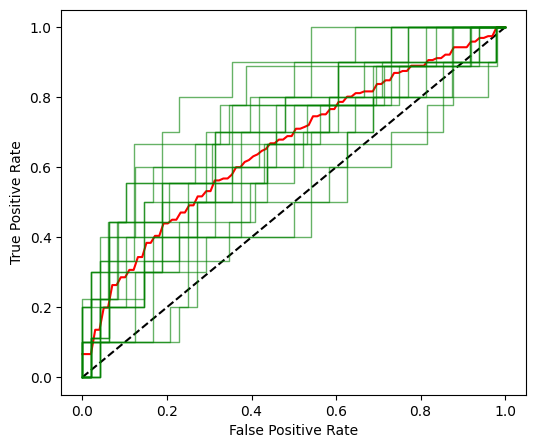

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

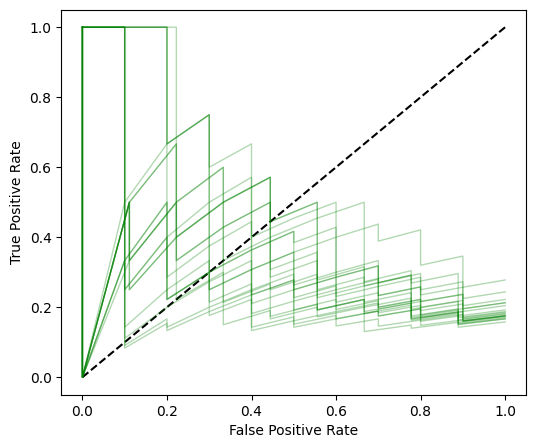

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)